In [2]:
%matplotlib inline

import seaborn as sns

import numpy as np
import scipy as sp
import nibabel as nib
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.image import grid_to_graph

sns.set(font_scale=1.4)
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
nibfile = nib.load("data/stats_downsample4D.nii")
data = nibfile.get_data()

In [4]:
feature_names = [
    "g_ratio",
    "axon_equiv_diameter",
    "myelin_equiv_diameter",
    "myelin_thickness",
    "myelin_area",
    "axon_area",
    "number_axons",
    "axon_equiv_diameter_std",
    "axon_equiv_diameter_axon_volume_corrected",
    "mvf",
    "avf",
    "fr",
    "solidity",
    "eccentricity",
    "orientation",
    "orientation_dispersion",
    "circularity"
]

In [5]:
data = data.transpose((1, 0, 2, 3))

# Ignore solidity, eccent., orient., etc.
data = data[..., 0:12]
data = data.squeeze(axis=2)

In [6]:
data.shape

(51, 66, 12)

In [7]:
original_shape = data.shape[0:2]

In [8]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

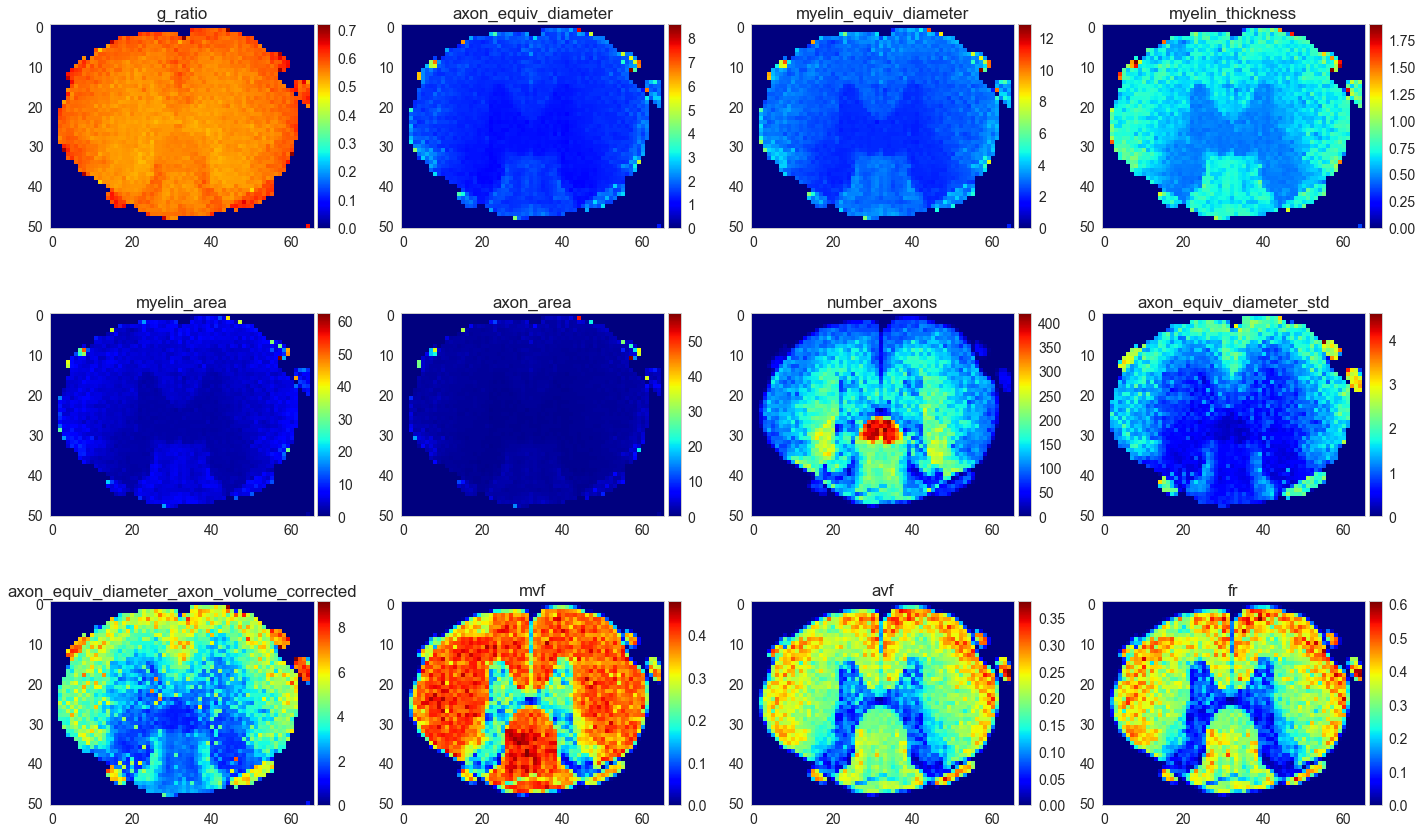

In [9]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, data.shape[2]+1):
    ax = fig.add_subplot(5, 4, i)
    img = ax.imshow(data[..., i-1], cmap="jet")
    plt.title(feature_names[i-1])
    colorbar(img)

plt.tight_layout(h_pad=1)

In [10]:
connectivity = grid_to_graph(n_x=data.shape[0],
                             n_y=data.shape[1])

In [11]:
data = data.reshape(-1, data.shape[2])

In [12]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [13]:
data.shape

(3366, 12)

# t-SNE

In [14]:
data_embedded = TSNE(n_components=2, verbose=3, perplexity=40).fit_transform(data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3366 samples in 0.010s...
[t-SNE] Computed neighbors for 3366 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3366
[t-SNE] Computed conditional probabilities for sample 2000 / 3366
[t-SNE] Computed conditional probabilities for sample 3000 / 3366
[t-SNE] Computed conditional probabilities for sample 3366 / 3366
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.291s
[t-SNE] Iteration 50: error = 66.3683319, gradient norm = 0.1772248 (50 iterations in 6.732s)
[t-SNE] Iteration 100: error = 61.8062210, gradient norm = 0.1247030 (50 iterations in 4.770s)
[t-SNE] Iteration 150: error = 56.1453934, gradient norm = 0.1033507 (50 iterations in 4.633s)
[t-SNE] Iteration 200: error = 55.6031265, gradient norm = 0.0816976 (50 iterations in 4.759s)
[t-SNE] Iteration 250: error = 55.3758202, gradient norm = 0.0874477 (50 iterations in 4.466s)
[t-SNE] KL divergence after 250 iterat

In [15]:
num_clusters = 15
clustering = AgglomerativeClustering(linkage="ward", n_clusters=num_clusters,
                                     connectivity=connectivity)
clustering.fit(data)
labels = clustering.labels_

In [16]:
labels = labels.reshape(*original_shape)

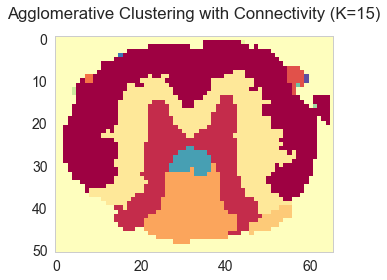

In [17]:
plt.imshow(labels, cmap="Spectral")
plt.title("Agglomerative Clustering with Connectivity (K={})".format(num_clusters), pad=18)
plt.tight_layout()

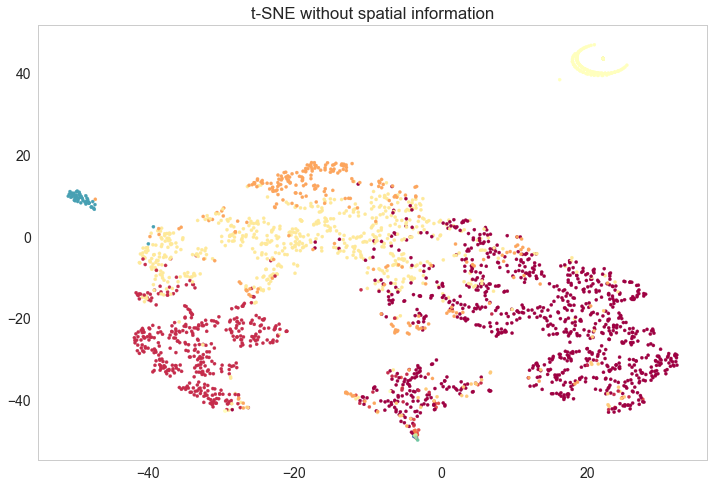

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(data_embedded[:, 0], data_embedded[:, 1],
            cmap="Spectral", s=10, c=clustering.labels_)
plt.title("t-SNE without spatial information")
plt.show()

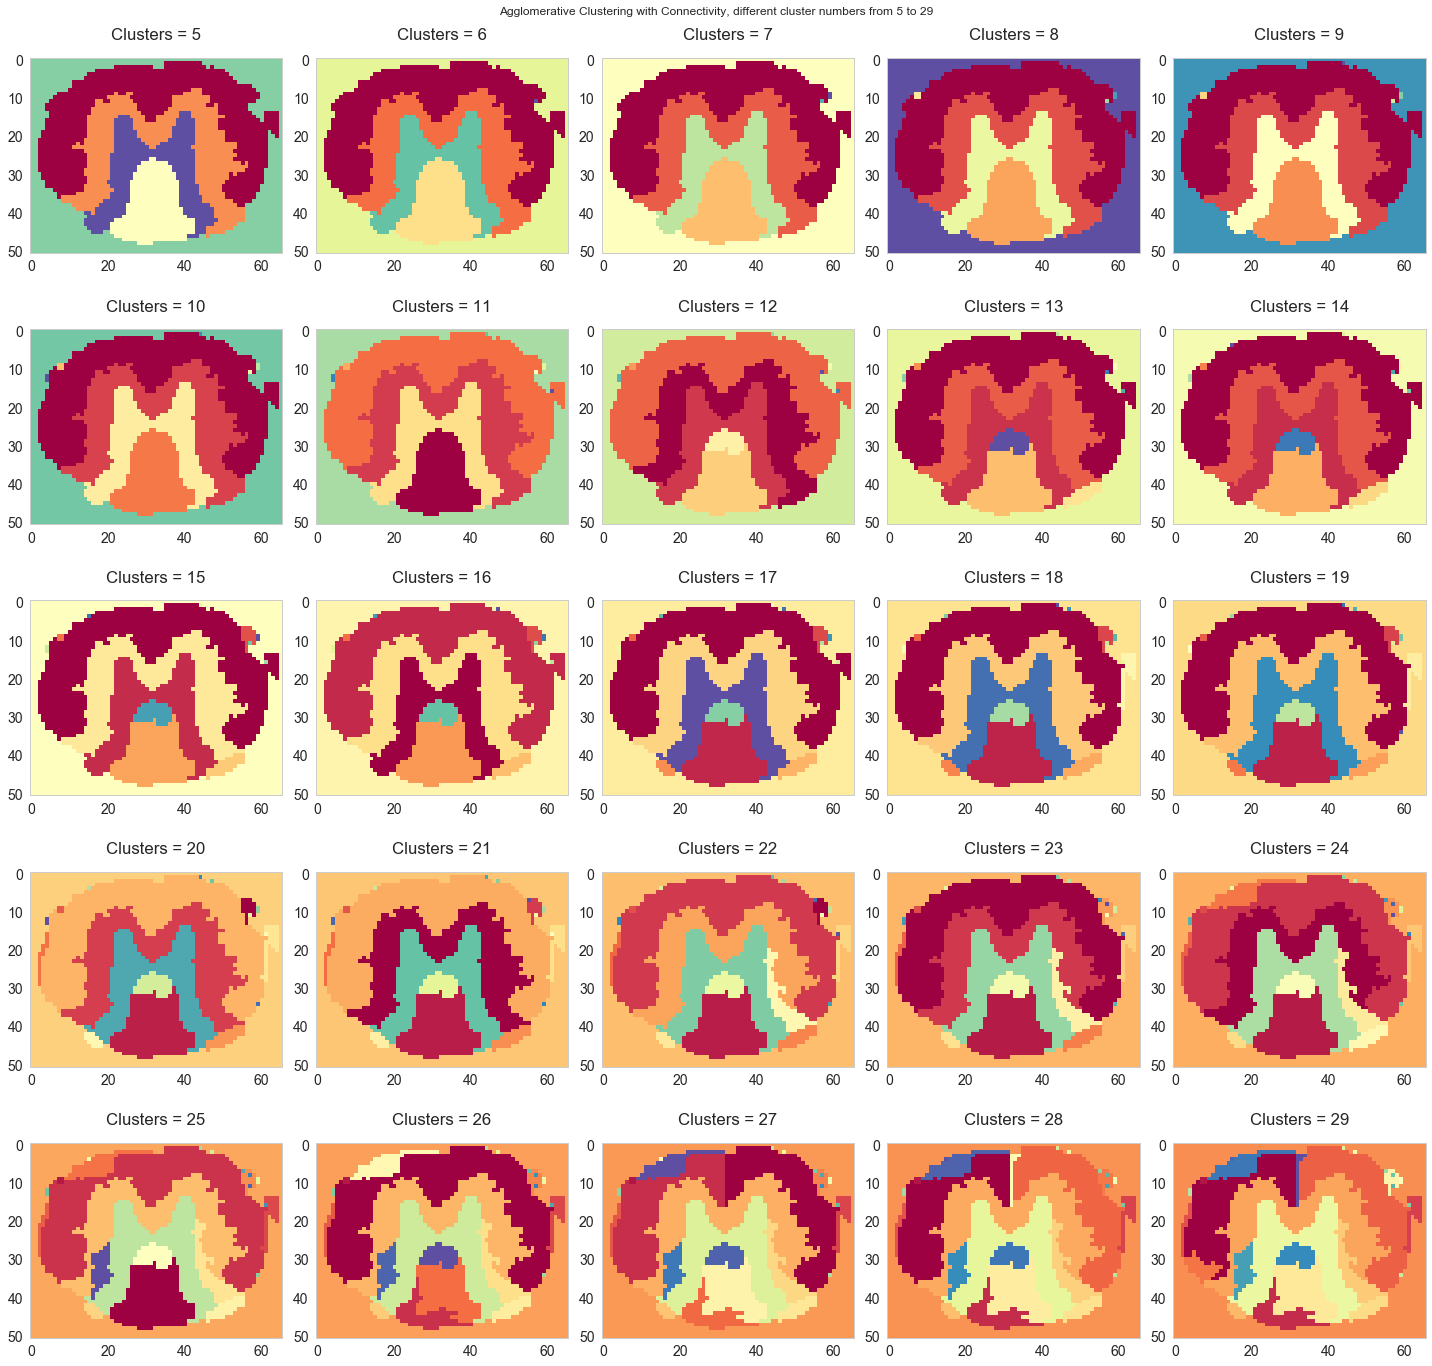

In [19]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 26):
    clustering = AgglomerativeClustering(linkage="ward", n_clusters=i+4,
                                         connectivity=connectivity)
    clustering.fit(data)
    labels = clustering.labels_
    labels = labels.reshape(*original_shape)

    ax = fig.add_subplot(5, 5, i)
    img = ax.imshow(labels, cmap="Spectral")
    plt.title("Clusters = {}".format(i+4), pad=18)
    plt.tight_layout()

plt.suptitle("Agglomerative Clustering with Connectivity, different cluster numbers from 5 to 29")
plt.tight_layout(h_pad=1)